EPSG:25832

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\osmnx\_overpass.py:211: UserWarning:

This area is 183 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.



Unhandled geometry type: <class 'shapely.geometry.point.Point'>
Unhandled geometry type: <class 'shapely.geometry.point.Point'>
Unhandled geometry type: <class 'shapely.geometry.linestring.LineString'>
Unhandled geometry type: <class 'shapely.geometry.linestring.LineString'>
Unhandled geometry type: <class 'shapely.geometry.linestring.LineString'>
GeoJSON file saved as: Germany_postal_codes.geojson


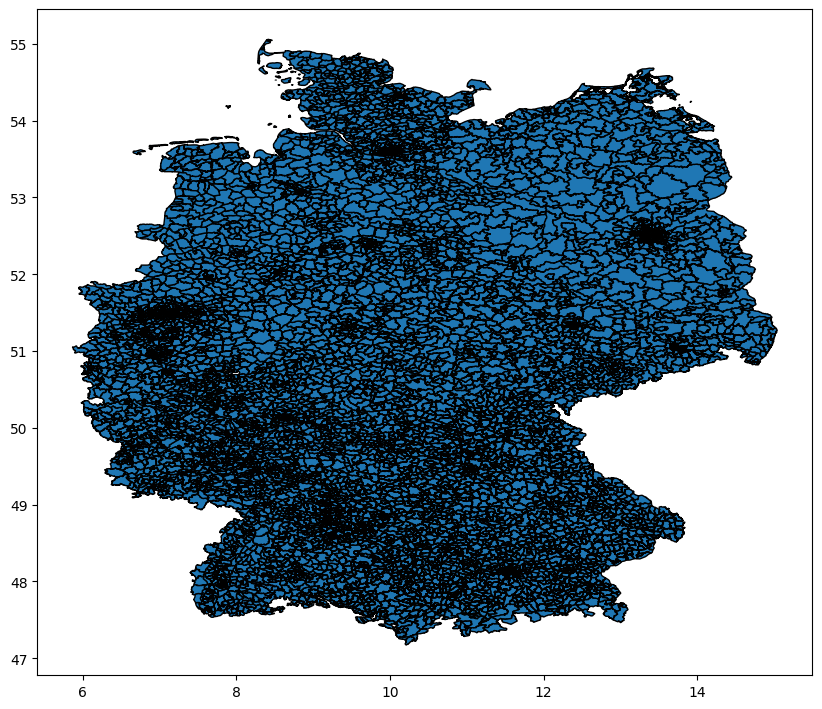

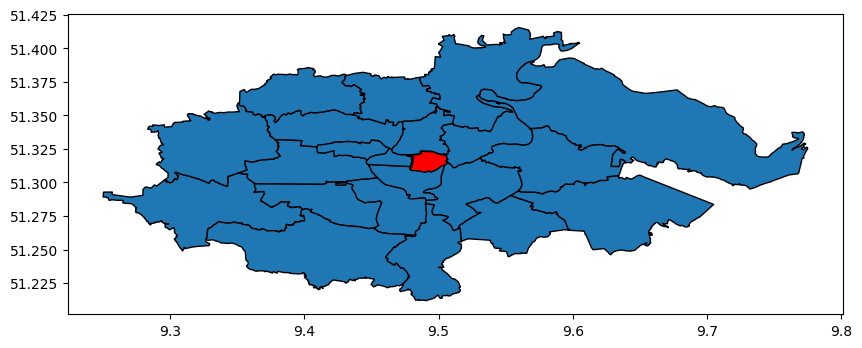

In [4]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon
import geojson

def handle_multipolygon(multipolygon):
    if isinstance(multipolygon, MultiPolygon):
        # Convert MultiPolygon to a list of Polygons
        polygons = [Polygon(list(poly.exterior.coords)) for poly in multipolygon.geoms]
        return polygons
    elif isinstance(multipolygon, Polygon):
        return [multipolygon]
    else:
        print(f"Unhandled geometry type: {type(multipolygon)}")
        return []

# Rest of the code remains the same...


def postal_code_polygon_dict_extractor(place_name, save_geojson=False):
    postal_code_polygons = ox.features_from_place(place_name, tags={"boundary": "postal_code"})

    gdf = gpd.GeoDataFrame(postal_code_polygons).dropna(subset=['postal_code', 'geometry'])

    postal_code_polygon_dict = {}

    for _, feature in gdf.iterrows():
        postal_code = feature['postal_code']
        geometry = feature['geometry']

        geometries = handle_multipolygon(geometry)

        postal_code_polygon_dict[postal_code] = geometries

    if save_geojson:
        geojson_filename = f"{place_name}_postal_codes.geojson"

        geojson_features = []
        for postal_code, geometries_list in postal_code_polygon_dict.items():
            for geometry in geometries_list:
                coordinates = list(geometry.exterior.coords)

                feature = {
                    "postal_code": postal_code,
                    "geometry": {
                        "type": geometry.geom_type,
                        "coordinates": coordinates
                    }
                }

                geojson_features.append(feature)

        with open(geojson_filename, 'w') as file:
            geojson.dump(geojson_features, file)

        print(f"GeoJSON file saved as: {geojson_filename}")

    return postal_code_polygon_dict

def plot_all_postal_code_polygons(gdf, highlight_postal_code=None, zoom_into_city=False):
    crs = "EPSG:25832"
    
    if zoom_into_city:
        # Get the bounding box of the GeoDataFrame
        bbox = gdf.total_bounds
        margin = 0.1  # 10% margin
        bbox_expanded = [bbox[0] - margin, bbox[1] - margin, bbox[2] + margin, bbox[3] + margin]
        gdf = gdf.cx[bbox_expanded[0]:bbox_expanded[2], bbox_expanded[1]:bbox_expanded[3]]

    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Set the CRS for the GeoDataFrame
    gdf.crs = crs
    
    # Plot the map with the GeoDataFrame and apply the specified projection
    gdf.to_crs(crs).plot(ax=ax, edgecolor='k')

    if highlight_postal_code is not None:
        highlight_geometry = gdf[gdf['postal_code'] == highlight_postal_code].to_crs(crs)
        highlight_geometry.plot(color='red', edgecolor='black', ax=ax)

    # Display the map
    plt.show()

# Example usage for Germany with saving GeoJSON data, using EPSG:25832,
# and optionally zooming into Kassel and highlighting a postal code
place_postal_code_polygons_germany = postal_code_polygon_dict_extractor("Germany", save_geojson=True)
highlight_postal_code_germany = "34117"
gdf_germany = gpd.GeoDataFrame(geometry=[geometry for geometries in place_postal_code_polygons_germany.values() for geometry in geometries])
gdf_germany['postal_code'] = [postal_code for postal_code in place_postal_code_polygons_germany.keys() for _ in place_postal_code_polygons_germany[postal_code]]
zoom_into_city = True
highlight_postal_code_kassel = "34117"

# Plot Germany map with highlighted postal code
plot_all_postal_code_polygons(gdf_germany, highlight_postal_code=highlight_postal_code_germany, zoom_into_city=zoom_into_city)

# Optionally, you can zoom into Kassel and highlight a postal code
if zoom_into_city:
    place_postal_code_polygons_kassel = postal_code_polygon_dict_extractor("Kassel")
    gdf_kassel = gpd.GeoDataFrame(geometry=[geometry for geometries in place_postal_code_polygons_kassel.values() for geometry in geometries])
    gdf_kassel['postal_code'] = [postal_code for postal_code in place_postal_code_polygons_kassel.keys() for _ in place_postal_code_polygons_kassel[postal_code]]

    # Plot Kassel map with highlighted postal code
    plot_all_postal_code_polygons(gdf_kassel, highlight_postal_code=highlight_postal_code_kassel)


In [19]:
import dash
import dash_leaflet as dl
from dash import html
import json

# Function to create a GeoJSON object for Dash Leaflet
def create_geojson_objects(geojson_data):
    # Check if the GeoJSON is a FeatureCollection or a list of features
    if 'features' in geojson_data:
        features = geojson_data['features']
    else:
        features = geojson_data

    # Create a list to store GeoJSON objects for each feature
    geojson_objects = []

    # Counter to handle duplicate postal codes
    counter = {}

    for feature in features:
        postal_code = feature['postal_code']

        # If the postal code is not unique, append a counter
        if postal_code in counter:
            counter[postal_code] += 1
            geojson_id = f"geojson-layer-{postal_code}-{counter[postal_code]}"
        else:
            counter[postal_code] = 1
            geojson_id = f"geojson-layer-{postal_code}"

        # Extract coordinates from each feature
        coordinates = feature['geometry']['coordinates']

        # Create GeoJSON object for each feature
        geojson_objects.append(dl.GeoJSON(data={
            "type": "FeatureCollection",
            "features": [{
                "type": "Feature",
                "properties": {
                    "postal_code": postal_code
                },
                "geometry": {
                    "type": feature['geometry']['type'],
                    "coordinates": coordinates
                }
            }]
        }, id=geojson_id, options=dict(style={'opacity': 1, 'dashArray': '9', 'fillOpacity': 0.5, 'weight': 1})))

    return geojson_objects

# Specify the GeoJSON filename
geojson_filename_germany = "Germany_postal_codes.geojson"

# Load GeoJSON data
with open(geojson_filename_germany, 'r') as file:
    geojson_data = json.load(file)

# Create the Dash app
app = dash.Dash(__name__)

# Layout of the app
app.layout = html.Div([
    dl.Map([
        dl.TileLayer(),
        *create_geojson_objects(geojson_data)  # Unpack the list of GeoJSON objects
    ],
    center=[51.1657, 10.4515],  # Specify the center coordinates of the map
    zoom=6  # Specify the initial zoom level
    )
])

if __name__ == '__main__':
    app.run_server(debug=True)


Test

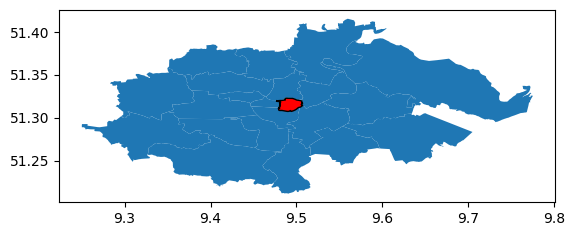

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\osmnx\_overpass.py:211: UserWarning: This area is 183 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001DCD13B1F70>>
Traceback (most recent call last):
  File "C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 785, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Program Files\Python312\Lib\threading.py", line 1534, in enumerate
    def enumerate():
    
KeyboardInterrupt: 


In [8]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon

def handle_multipolygon(multipolygon):
    # Check if it's a MultiPolygon and handle accordingly
    if isinstance(multipolygon, MultiPolygon):
        # Convert MultiPolygon to a list of Polygons
        polygons = [polygon for polygon in multipolygon.geoms]
        return polygons
    elif isinstance(multipolygon, Polygon):
        # If it's a single Polygon, return it in a list
        return [multipolygon]
    else:
        # Handle other cases if needed
        print(f"Unhandled geometry type: {type(multipolygon)}")
        return []

def postal_code_polygon_dict_extractor(place_name):
    # Find Postal Code Polygons for Place
    postal_code_polygons = ox.features_from_place(place_name, tags={"boundary": "postal_code"})

    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(postal_code_polygons).dropna(subset=['postal_code', 'geometry'])

    # Create a dictionary mapping postal codes to their respective geometries
    postal_code_polygon_dict = {}

    for _, feature in gdf.iterrows():
        postal_code = feature['postal_code']
        geometry = feature['geometry']

        # Check if the geometry is a MultiPolygon and handle it accordingly
        geometries = handle_multipolygon(geometry)

        # Add the geometries to the dictionary
        postal_code_polygon_dict[postal_code] = geometries

    return postal_code_polygon_dict

def plot_all_postal_code_polygons(place_postal_code_polygons, highlight_postal_code=None):
    # Create a GeoDataFrame with all the geometries
    all_geometries = [geometry for geometries in place_postal_code_polygons.values() for geometry in geometries]
    gdf = gpd.GeoDataFrame(geometry=all_geometries)

    # Plot all the postal code polygons
    gdf.plot()

    if highlight_postal_code is not None:
        # Highlight the specified postal code on the Germany plot
        highlight_geometry = place_postal_code_polygons.get(highlight_postal_code, [])
        highlight_gdf = gpd.GeoDataFrame(geometry=highlight_geometry)
        highlight_gdf.plot(color='red', edgecolor='black', ax=plt.gca())

    # Display the map
    plt.show()

# Example usage for Kassel
place_postal_code_polygons_kassel = postal_code_polygon_dict_extractor("Kassel")
plot_all_postal_code_polygons(place_postal_code_polygons_kassel, highlight_postal_code="34117")

# Example usage for Germany
place_postal_code_polygons_germany = postal_code_polygon_dict_extractor("Germany")
highlight_postal_code_germany = "34117"
plot_all_postal_code_polygons(place_postal_code_polygons_germany, highlight_postal_code=highlight_postal_code_germany)
